#########################################
### Alunos: Alaf Santos e João Macedo ###
#########################################

```
Calcular a homografia entre duas imagens, usando:
- DLT Normalizado 
- RANSAC para eliminar os outliers
- Processo de otimização para se obter uma estimativa mais precisa da homografia (pode ser usada uma função de 
    otimização do Numpy ou qualquer outra biblioteca, mas a função de custo tem que ser definida por vocês)
```



In [120]:
#Instalando e importando dependências 
!pip install imgaug==0.2.5
!pip install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import imutils
import random
from scipy.optimize import minimize, root, least_squares

# **Definições de Funções**

In [121]:
#------------------------------------------------------------------------------------------------------------------
def myRansac(src_pts, dst_pts):
  e, p, N, s = 0.5,0.99,100,4
  qtd_inliers, dist_Var, dist_Var_Atual = 0, 0, 0
  maxInliers = -1
  qtd_pts = len(src_pts)
  indx_Points = np.linspace(0,qtd_pts-1,qtd_pts)
  rand_Indx = np.zeros((4,))
  maskInliers_t = np.ones(qtd_pts)
  src_t = np.ones((4,3))
  dst_t = np.ones((4,3))

  for count in range(0,N): #mudar o 100 pro N depois
    #tratar da possivel colinearidade de pontos
    while True:
 
      for i in range(0,3):
        rand_Indx[i] = random.choice(indx_Points)

      for i in range(0,len(rand_Indx)):
        src_t[i][:] = src_pts[int(rand_Indx[i])][:]
        dst_t[i][:] = dst_pts[int(rand_Indx[i])][:]
 
      det1 = np.ceil(np.linalg.det(np.array([src_t[0,:],src_t[1,:],src_t[2,:]])))
      det2 = np.ceil(np.linalg.det(np.array([src_t[0,:],src_t[1,:],src_t[3,:]])))
      det3 = np.ceil(np.linalg.det(np.array([src_t[1,:],src_t[2,:],src_t[3,:]])))
      det4 = np.ceil(np.linalg.det(np.array([src_t[0,:],src_t[2,:],src_t[3,:]])))
            
      if ((det1!=0) and (det2!=0) and (det3!=0) and (det4!=0)):
          break

    h_t, T1, T2 = normalizedDLT(src_t, dst_t)
    h_t = np.dot(np.dot(T2,h_t),T1)
 
    #calcular os inliers

    qtd_inliers, dist_Var_Atual, maskInliers_t = inliers(h_t,src_pts,dst_pts,maskInliers_t)
    
    if ((qtd_inliers > maxInliers) or ((qtd_inliers == maxInliers) and (dist_Var_Atual < dist_Var))): 
      maxInliers = qtd_inliers
      H = h_t
      dist_Var = dist_Var_Atual

    e = (qtd_pts - qtd_inliers)/qtd_pts
    N = int((np.log10(1-p))/(np.log10(1-pow(1-e,s))))
 
  return H
#------------------------------------------------------------------------------------------------------------------
def inliers(temp_H, src_pts, dst_pts, temp_Mask_Inliers):
  qtd_Inliers, sum_Dist, dist_Atual, dist_Var_Atual = 0, 0, 0, 0
  dists = []
  #resolve o problema da matriz singular
  if np.linalg.det(temp_H) == 0:
    inv_H = np.linalg.pinv(temp_H)
  else:
    inv_H = np.linalg.inv(temp_H)
 
  for i in range(0,len(src_pts)):
    x_1 = src_pts[i]
    x_2 = dst_pts[i]
 
    x_1_i = np.transpose(np.dot(temp_H,np.transpose(x_1)))
    x_2_i = np.transpose(np.dot(inv_H,np.transpose(x_2)))
    
    x_1_i /= x_1_i[2]
    x_2_i /= x_2_i[2]
 
    dist_Atual = pow((x_1[0]-x_2_i[0]),2) + pow((x_1[1]-x_2_i[1]),2) + pow((x_2[0]-x_1_i[0]),2) + pow((x_2[1]-x_1_i[1]),2)
 
    #define inlier pela distancia geometrica
    if (dist_Atual < 70): #na mão (talvez resolver com um for)
      qtd_Inliers += 1
      temp_Mask_Inliers[i] = 1
      dists.append(dist_Atual)
      sum_Dist += dist_Atual
 
    else:
       temp_Mask_Inliers[i] = 0
  
  dist_Media = sum_Dist/qtd_Inliers
 
  for i in range(0,len(dists)):
 
    dist_Var_Atual += pow((dists[i]-dist_Media),2)
 
  dist_Var_Atual /= (qtd_Inliers-1)
 
  return qtd_Inliers, dist_Var_Atual, temp_Mask_Inliers
#------------------------------------------------------------------------------------------------------------------
def normalizedDLT(src, dst):

  #normalizando os pontos antes do DLT
  src, Tsrc = Normalization(src)
  dst, Tdst = Normalization(dst)

  a = np.zeros((8,9)) #Assemble n 2x9 matrices Ai into a single 2nx9 matrix A

  i = 0
  while i <= 3:
    a[(2*i),3:6]   = -dst[i][2]*src[i]
    a[(2*i),6:9]   =  dst[i][1]*src[i]
    a[(2*i+1),0:3] =  dst[i][2]*src[i]
    a[(2*i+1),6:9] = -dst[i][0]*src[i]
    i+=1
 
  _, _, vh = np.linalg.svd(a, full_matrices=True) #https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html
  h = vh[-1,:].reshape(3, 3) #Obtain SVD of A. Solution for h is last column of V

  return h, Tsrc, np.linalg.inv(Tdst)
#------------------------------------------------------------------------------------------------------------------
def Normalization(pts):
  #calcular centroide e tornar ele a origem
  averageX = 0
  averageY = 0
  for i in range(0,len(pts)):
    averageX = pts[i,0]/len(pts)
    averageY = pts[i,1]/len(pts)
  
  dist = 0  
  for i in range(0,len(pts)):
    argX = (pts[i,0]-averageX)*(pts[i,0]-averageX)
    argY = (pts[i,1]-averageY)*(pts[i,1]-averageY) 
    dist += np.sqrt(argX + argY)/len(pts)  
  
  #escalar as distancias medias por raiz de 2
  s = np.sqrt(2)/dist
  tX = -s*averageX
  tY = -s*averageY
  T = [[s,0,tX],[0,s,tY],[0,0,1]]
  pts = np.transpose(np.dot(T,np.transpose(pts)))
  
  return pts, T
#------------------------------------------------------------------------------------------------------------------
def symmetric_transfer_error(H, src, dst):
  H = H.reshape((3, 3))
  H_inv = np.linalg.inv(H)

  src = np.transpose(src)
  dst = np.transpose(dst)
  
  dst_pred = np.dot(H, src)
  src_pred = np.dot(H_inv, dst)
 
  src_loss = np.linalg.norm((src_pred/src_pred[-1,:])-src, axis=0)
  dst_loss = np.linalg.norm((dst_pred/dst_pred[-1,:])-dst, axis=0)
  cost = src_loss + dst_loss
 
  return cost
#------------------------------------------------------------------------------------------------------------------
def optimize(H_ini, src, dst):
  res = root(symmetric_transfer_error, H_ini, args=(src, dst), method='lm', options={'xtol': 1e-08, 'maxiter': 5000})
  H = res.x.reshape((3, 3))
  H = H/H[-1,-1]
  return H
#------------------------------------------------------------------------------------------------------------------
def myFindHomography(src_pts, dst_pts):
  H = myRansac(src_pts,dst_pts) #DLT normalizado dentro do ransac, processo iterativo 
  H = optimize(H, src_pts, dst_pts) #otimizando a matriz que saiu do ransac
  return H
#------------------------------------------------------------------------------------------------------------------

# **Código Principal**

Homography optimized with Symmetric Transfer Error: 
 [[ 6.48401459e-01 -7.92814460e-02  3.45964095e+01]
 [-7.60597915e-02  7.46582291e-01  8.81548450e+00]
 [-3.46161390e-04 -9.78892435e-05  1.00000000e+00]]


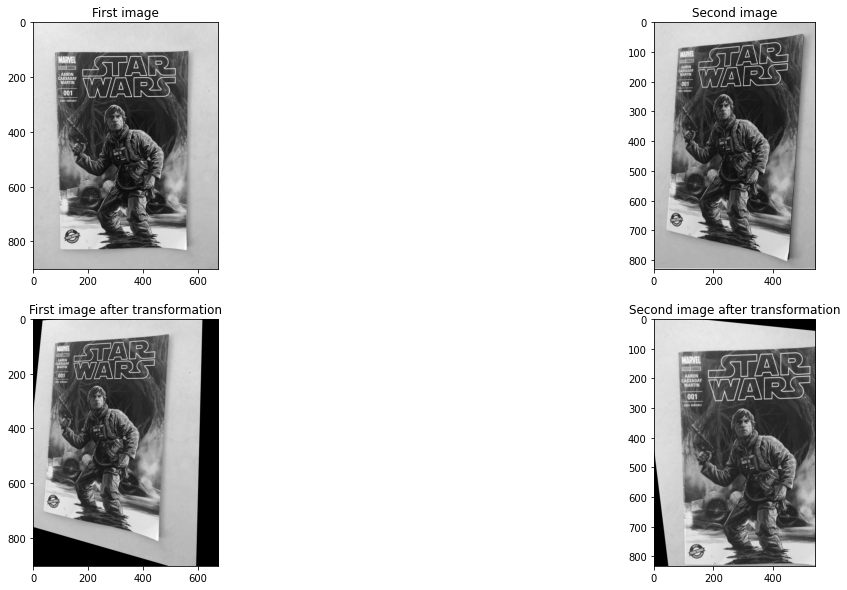

In [122]:
#Definindo a main - carrega imagem e chama método de homografia para entao plotar as transformações
def main(): 
  #carregando imagens e fazendo e definindo os pontos a usar na homografia
  img1 = cv.imread('comicsStarWars01.jpg',0)          
  img2 = cv.imread('comicsStarWars02.jpg',0)

  #img1 = cv.imread('outdoors01.jpg',0)          
  #img2 = cv.imread('outdoors02.jpg',0)

  #img1 = cv.imread('minions02a.jpg',0)          
  #img2 = cv.imread('minions01a.jpg',0)

  #img1 = cv.imread('photo01a.jpg',0)          
  #img2 = cv.imread('box.jpg',0)
  
  FLANN_INDEX_KDTREE = 1
  sift = cv.xfeatures2d.SIFT_create()
 
  kp1, des1 = sift.detectAndCompute(img1,None)
  kp2, des2 = sift.detectAndCompute(img2,None)
 
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  search_params = dict(checks = 50)
  flann = cv.FlannBasedMatcher(index_params, search_params)
  matches = flann.knnMatch(des1,des2,k=2)
 
  good = []
  for m,n in matches:
      if m.distance < 0.75*n.distance:
          good.append(m)
         
  src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
  dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
 
  num = src_pts.shape[0]
  src = np.ones((num,3))
  dst = np.ones((num,3))
 
  for i in range(0,num):
     src[i,0] = src_pts[i][0][0]
     src[i,1] = src_pts[i][0][1]
     dst[i,0] = dst_pts[i][0][0]
     dst[i,1] = dst_pts[i][0][1]

  #chamada do nosso metodo de homografia otimizada
  M = myFindHomography(src,dst)
  print('Homography optimized with Symmetric Transfer Error: \n', M)

  #aplica a matriz de homografia nas imagens de entrada
  img3 = cv.warpPerspective(img1, M, (img1.shape[1],img1.shape[0]))
  img4 = cv.warpPerspective(img2, np.linalg.inv(M), (img2.shape[1],img2.shape[0]))  

  #plota as imagens originais e as transformadas
  fig = plt.figure(figsize=(20,10))
  ax1 = fig.add_subplot(2,2,1)
  plt.title('First image')
  plt.imshow(img1, 'gray')
  ax1 = fig.add_subplot(2,2,2)
  plt.title('Second image')
  plt.imshow(img2, 'gray')
  ax1 = fig.add_subplot(2,2,3)
  plt.title('First image after transformation')
  plt.imshow(img3, 'gray')
  ax1 = fig.add_subplot(2,2,4)
  plt.title('Second image after transformation')
  plt.imshow(img4, 'gray')
  plt.show()
#------------------------------------------------------------------------------------------------------------------
if __name__ == '__main__':
  main()
  